# Objective
- base model without oversampling and feature selection & fine tune it
- base model with oversampling and feature selection & fine tune it

In [ ]:
import warnings

import pandas as pd
from numpy import arange
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.feature_selection import chi2,SelectKBest
from imblearn.over_sampling import SMOTE
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold, KFold
from importlib import reload
import models.uci_heart_disease_dataset as uci
import custom_libs.evaluation_helper as ev

warnings.filterwarnings("ignore")

In [ ]:
# Load the preprocessed dataset (299 records; with 14 features).
data = pd.read_csv(uci.UCIHeartDiseaseDataFile.cleveland_preprocessed, names = uci.get_standard_features())
print(f'Data shape: {data.shape}.')
data.head(3)

### Parameters for SVM

In [ ]:
# Verbose variable for log inspection.
verbose = False

# Dictionary to hold hyperparameters for grid search.
parameters = dict()
parameters['kernel'] = ['rbf', 'poly', 'linear', 'sigmoid']
# Tried even with 30 - takes longer but still chooses 1.
parameters['C'] = arange(1, 10, 1)
parameters['gamma'] = ['scale', 'auto']
parameters['class_weight'] = ['dict', 'balanced']

# A stratified K fold for cross validation strategy - values are assigned from the global class.
skfolds = StratifiedKFold(n_splits = ev.kfold_n_split,
                          shuffle = ev.kfold_shuffle,
                          random_state = ev.random_state)

In [ ]:
reload(ev)
# A function to build base model.
# Acknowledgement: Code was referenced from Prof. Mafas Raheem's AML lab-8.
def build_and_validate_base_model(x_set, y_set, test_name):
    # Calls the evaluation helper module to Scale and do train/test split.
    x_train, x_test, y_train, y_test = ev.scale_and_split(x_set, y_set)

    print(f'\nEvaluation name: {test_name}.')

    # Train the model with training set.
    svc= SVC(verbose=verbose)
    svc.fit(x_train, y_train)

    # Do prediction with the train model.
    y_pred = svc.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curve
    ev.display_validation_report(y_test, y_pred, x_test, svc, test_name)

In [ ]:
reload(ev)
# A function to build and fine tune model using GridSearchCV.
# Acknowledgement: Code was referenced from Prof. Mafas Raheem's AML lab-8.
def build_and_validate_with_grid_search_cv(x_set, y_set, test_name):
    # Calls the evaluation helper module to Scale and do train/test split.
    x_train, x_test, y_train, y_test = ev.scale_and_split(x_set, y_set)

    print(f'\nEvaluation name: {test_name}.')

    grid_svc= SVC(verbose=verbose)

    ## Building Grid Search algorithm with cross-validation and acc score.
    grid_search_svc = GridSearchCV(grid_svc, parameters, scoring='accuracy', cv=skfolds)

    # Train and discover the model's hyperparameters for optimal result.
    grid_search_svc.fit(x_train,y_train)

    # Display the best hyperparameters and score.
    print(f'Best params          :{grid_search_svc.best_params_}.')
    print(f'Best score (*mean)   :{grid_search_svc.best_score_}.')

    # Predict using the trained model.
    y_pred = grid_search_svc.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curve
    ev.display_validation_report(y_test, y_pred, x_test, grid_search_svc, test_name)

In [ ]:
reload(ev)
# A function to build and fine tune model using RandomSearchCV.
# Acknowledgement: Code was referenced from Prof. Mafas Raheem's AML lab-8.
def build_and_validate_with_random_search_cv(x_set, y_set, test_name):
    # Calls the evaluation helper module to Scale and do train/test split.
    x_train, x_test, y_train, y_test = ev.scale_and_split(x_set, y_set)

    print(f'\nEvaluation name: {test_name}.')

    rand_svc= SVC(verbose=verbose)

    ## Building Random Search algorithm with cross-validation and acc score.
    rand_search_svc = RandomizedSearchCV(rand_svc, parameters, scoring='accuracy', cv=skfolds)

    # Train and discover the model's hyperparameters for optimal result.
    rand_search_svc.fit(x_train,y_train)

    # Display the best hyperparameters and score.
    print(f'Best params :{rand_search_svc.best_params_}.')
    print(f'Best score  :{rand_search_svc.best_score_}.')

    # Predict using the trained model.
    y_pred = rand_search_svc.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curve
    ev.display_validation_report(y_test, y_pred, x_test, rand_search_svc, test_name)

### Standard Data (without over-sampling)

In [102]:
# Prepare features and target variables.
X = data.drop(uci.UCIHeartDiseaseData.target, axis=1)
y = data[uci.UCIHeartDiseaseData.target]

# Reset accuracies for SVM
ev.accuracies = {}


Evaluation name: std-base.

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.88      0.86        32
           1       0.85      0.82      0.84        28

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60


Confusion Matrix


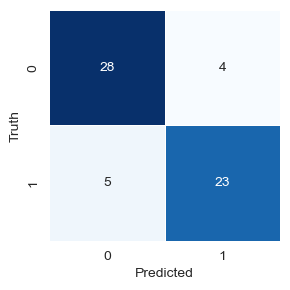

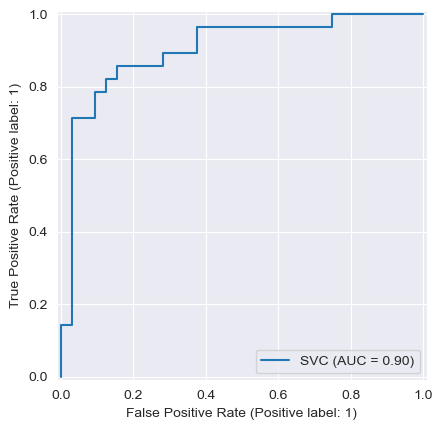

In [103]:
# Evaluation: Standard Base
build_and_validate_base_model(X, y,ev.EvaluationType.std_base)


Evaluation name: std-grid-scv.
Best params          :{'C': 2, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}.
Best score (*mean)   :0.8286347517730498.

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        32
           1       0.86      0.86      0.86        28

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60


Confusion Matrix


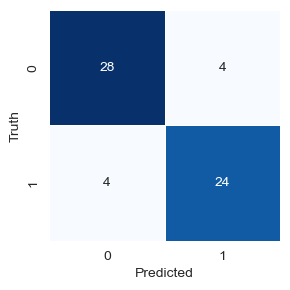

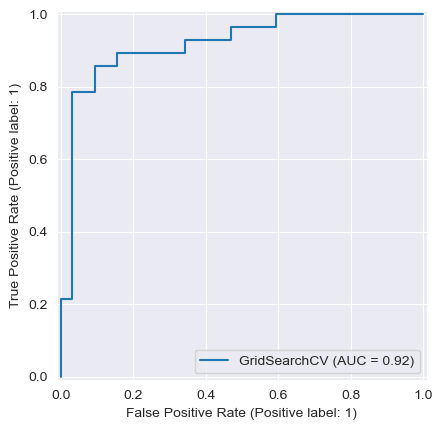

In [104]:
# Evaluation: Standard Grid Search CV
build_and_validate_with_grid_search_cv(X, y, ev.EvaluationType.std_grid_search_cv)


Evaluation name: std-rand-scv.
Best params :{'kernel': 'linear', 'gamma': 'auto', 'class_weight': 'balanced', 'C': 7}.
Best score  :0.8286347517730498.

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        32
           1       0.86      0.86      0.86        28

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60


Confusion Matrix


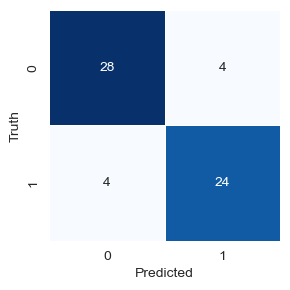

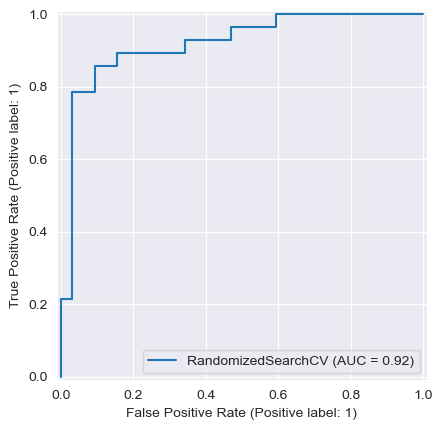

In [105]:
# Evaluation: Standard Random Search CV
build_and_validate_with_random_search_cv(X, y, ev.EvaluationType.std_random_search_cv)

In [106]:
print(ev.accuracies)

{'std-base': 85, 'std-grid-scv': 87, 'std-rand-scv': 87}


### Data with over-sampling and feature selection

In [ ]:
chi_squared = SelectKBest(score_func=chi2, k=13)
chi_squared.fit(X, y)
feature_score = pd.DataFrame({"Score":chi_squared.scores_, "P_Value":np.round(chi_squared.pvalues_,3)}, index=X.columns)
feature_score.nlargest(n=13,columns="Score")

In [ ]:
chi_squared = SelectKBest(score_func=chi2, k=9)
X_fs = chi_squared.fit_transform(X, y)

In [ ]:
X_b, y_b = SMOTE().fit_resample(X_fs, y)
X_b.shape

build_and_validate_base_model(X_b, y_b)

In [ ]:
fine_tuned_model_with_random_search_cv(X_b, y_b)

In [ ]:
build_and_validate_with_grid_search_cv(X_b, y_b)